# Student Performance Analysis

### Data Pre-processing

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency


In [2]:
# Load data
student_data = pd.read_csv('Student_performance_10k.csv')
student_data.head(3).T

,0,1,2
roll_no,std-01,std-02,std-03
gender,male,male,male
race_ethnicity,group D,group B,group C
parental_level_of_education,some college,high school,master's degree
lunch,1.0,1.0,1.0
test_preparation_course,1.0,0.0,0.0
math_score,89,65,10
reading_score,38.0,100.0,99.0
writing_score,85.0,67.0,97.0
science_score,26.0,96.0,58.0


In [3]:
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   roll_no                      9999 non-null   object 
 1   gender                       9982 non-null   object 
 2   race_ethnicity               9977 non-null   object 
 3   parental_level_of_education  9978 non-null   object 
 4   lunch                        9976 non-null   float64
 5   test_preparation_course      9977 non-null   float64
 6   math_score                   9976 non-null   object 
 7   reading_score                9975 non-null   float64
 8   writing_score                9976 non-null   float64
 9   science_score                9977 non-null   float64
 10  total_score                  9981 non-null   float64
 11  grade                        9997 non-null   object 
dtypes: float64(6), object(6)
memory usage: 937.6+ KB


In [4]:
# Obtain number of null values per column
student_data.isna().sum()

roll_no                         1
gender                         18
race_ethnicity                 23
parental_level_of_education    22
lunch                          24
test_preparation_course        23
math_score                     24
reading_score                  25
writing_score                  24
science_score                  23
total_score                    19
grade                           3
dtype: int64

In [5]:
# Drop null values and calculate percentage of dropped data
pre_drop_num_rows = student_data.shape[0]
student_data = student_data.dropna()
post_drop_num_rows = student_data.shape[0]
percentage_dropped = ((pre_drop_num_rows - post_drop_num_rows)/pre_drop_num_rows)*100

print(f'Percentage of dropped data: {percentage_dropped}%')

# Confirm non-null dataset
student_data.isna().sum()

Percentage of dropped data: 2.13%


roll_no                        0
gender                         0
race_ethnicity                 0
parental_level_of_education    0
lunch                          0
test_preparation_course        0
math_score                     0
reading_score                  0
writing_score                  0
science_score                  0
total_score                    0
grade                          0
dtype: int64

In [6]:
# Handle data consistency

# Convert lunch and test_preparation_course to categories
student_data['lunch'] = student_data['lunch'].astype('object')
student_data['lunch'] = student_data['lunch'].replace({0: 'No', 1: 'Yes'})

student_data['test_preparation_course'] = student_data['test_preparation_course'].astype('object')
student_data['test_preparation_course'] = student_data['test_preparation_course'].replace({0: 'No', 1: 'Yes'})

# math-score: dtype -> float
student_data['math_score'] = student_data['math_score'].replace('\\t41', '41')
student_data['math_score'] = student_data['math_score'].astype(float) 

# gender:  Inconsist labeling
pre_replacement = student_data['gender'].unique()
student_data['gender'] = student_data['gender'].replace(['Boy', '\\tmale'], 'male')
student_data['gender'] = student_data['gender'].replace('Girl', 'female')
post_replacement = student_data['gender'].unique()
print(f'Gender values from {pre_replacement} -> {post_replacement}')

# race_ethnicity: Inconsist labeling
pre_replacement = student_data['race_ethnicity'].unique()
student_data['race_ethnicity'] = student_data['race_ethnicity'].replace({'A': 'group A', 'B':'group B', 'D':'group D', 'E':'group E'})
student_data['race_ethnicity'] = student_data['race_ethnicity'].replace(['C', 'group C\\n'], 'group C')
post_replacement = student_data['race_ethnicity'].unique()
print(f'Race_Ethnicity values from {pre_replacement} -> {post_replacement}')

Gender values from ['male' 'Boy' '\\tmale' 'female' 'Girl'] -> ['male' 'female']
Race_Ethnicity values from ['group D' 'group B' 'group C' 'group E' 'group A' 'C' 'D' 'group C\\n'
 'B' 'E' 'A'] -> ['group D' 'group B' 'group C' 'group E' 'group A']


In [7]:
student_data.describe()

,math_score,reading_score,writing_score,science_score,total_score
count,9787.000000,9787.000000,9787.000000,9787.000000,9787.000000
mean,57.233780,70.155717,71.457035,66.073056,264.919587
std,21.710319,19.022840,18.239395,19.304388,42.303751
min,0.000000,17.000000,10.000000,9.000000,89.000000
25%,41.000000,57.000000,59.000000,53.000000,238.000000
50%,58.000000,71.000000,73.000000,67.000000,268.000000
75%,73.000000,85.000000,85.000000,81.000000,295.000000
max,100.000000,100.000000,100.000000,100.000000,383.000000


### Visualization and Measures of Centrality

In [8]:
# Obtain numeric data
numeric_df = student_data.select_dtypes(include='number')

# Obtain categorical data, exclude identifier
category_df = student_data.select_dtypes(include='object')
category_df.drop('roll_no', axis=1, inplace= True)

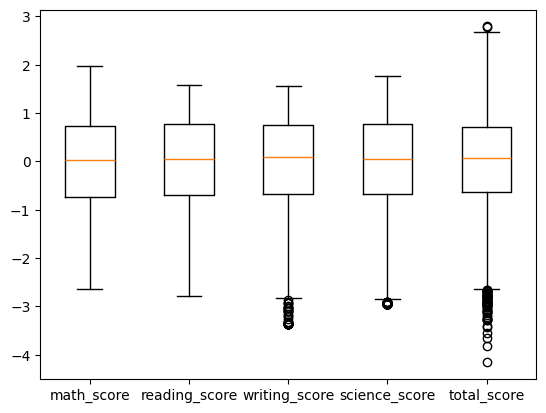

In [9]:
# Normalize numeric dataset
scaler = StandardScaler()
standardized_data = scaler.fit_transform(numeric_df)

plt.boxplot(standardized_data, tick_labels=numeric_df.columns)
plt.show()

The boxplots shown above reflect an approximate normal distribution for the math, science, and reading scores. On the other hand, writing presents a left sweked distribution due to outliers scoring below the `1.5*IQR` benchmark. Lastly, the overall score shows a significant number of outliers scoring poorly.

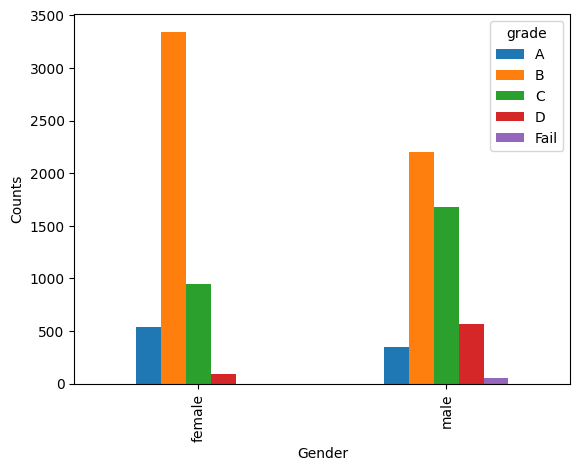

In [10]:
# Group by the 'Month' and Sub-group by Revenue
grouped_data = student_data.groupby(['gender'])['grade'].value_counts().unstack()
grouped_df = grouped_data.reset_index() # Converts result to DF

# Create bar plot
grouped_df.plot(x='gender', kind='bar')
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.show()

Females and males most prevalent grade is B.

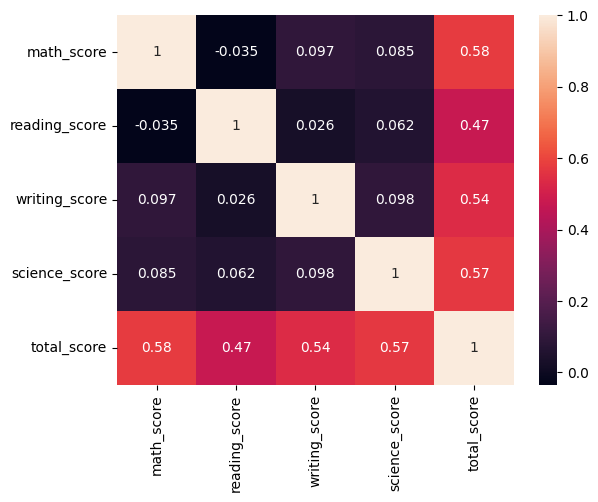

In [11]:
# Create the heatmap
sns.heatmap(numeric_df.corr(), annot=True, color='skyblue')
plt.show()

As shown in the heatmap above, there are no values higher than |.7|, there exists no correlation concerns among the numeric variables. 

In [12]:
# Chi-Square Test of Independence
contingency_table = pd.crosstab([category_df['gender'], category_df['race_ethnicity']], category_df['grade'])

chi2, p, dof, expected = chi2_contingency(contingency_table)
print('Chi-Square Statistic:', chi2)
print(dof)
print('P-Value:', p)
print(p < 0.05)

Chi-Square Statistic: 922.9564369008423
36
P-Value: 2.1793237235568403e-170
True


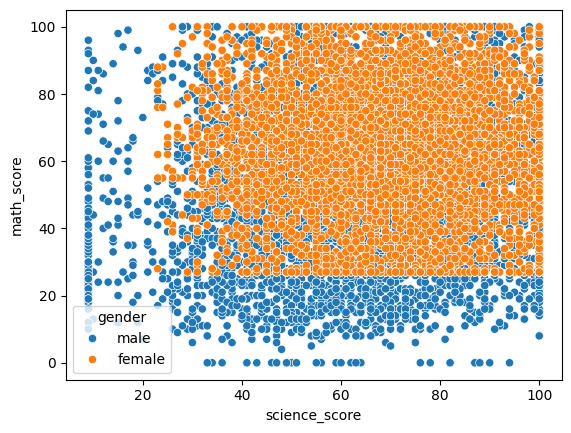

In [13]:
# scatter plot of scores by ethnicity, gender
sns.scatterplot(student_data,x='science_score', y='math_score', hue='gender' )
plt.show()

for col_name in student_data.columns:
    print(col_name, student_data[col_name].unique())

In [30]:
# Association
# TABLE 2: Association of Emissions Category by Fuel Type and Other Characteristics
contingency_table_gender = pd.crosstab(student_data['gender'], student_data['grade'])
contingency_table_race = pd.crosstab(student_data['race_ethnicity'], student_data['grade'])
contingency_table_parent_edu = pd.crosstab(student_data['parental_level_of_education'], student_data['grade'])
contingency_table_lunch = pd.crosstab(student_data['lunch'], student_data['grade'])
contingency_table_test_prep = pd.crosstab(student_data['test_preparation_course'], student_data['grade'])

In [36]:
def convert_data_to_proportions(contingency_table):
    for col_name in contingency_table.columns:
        row_sum = contingency_table[col_name].sum()
        contingency_table[col_name] = round((contingency_table[col_name]/row_sum)*100,2)
    return contingency_table

contingency_table_gender = convert_data_to_proportions(contingency_table_gender)
contingency_table_race = convert_data_to_proportions(contingency_table_race)
contingency_table_parent_edu = convert_data_to_proportions(contingency_table_parent_edu)
contingency_table_lunch = convert_data_to_proportions(contingency_table_lunch)
contingency_table_test_prep = convert_data_to_proportions(contingency_table_test_prep)

contingency_tables = [contingency_table_gender, contingency_table_race, contingency_table_parent_edu, contingency_table_test_prep, 
                      contingency_table_lunch]

for table in contingency_tables:
    print(table, '\n')

grade       A      B      C      D   Fail
gender                                   
female  60.56  60.32  36.15  13.66   3.28
male    39.44  39.68  63.85  86.34  96.72 

grade               A      B      C      D   Fail
race_ethnicity                                   
group A         10.17  10.91  10.20  11.08   3.28
group B         20.11  19.10  18.23  21.09  19.67
group C         29.39  29.78  28.73  26.56  27.87
group D         26.93  25.04  26.90  26.56  29.51
group E         13.41  15.17  15.94  14.72  19.67 

grade                            A      B      C      D   Fail
parental_level_of_education                                   
associate's degree           17.43  19.61  18.46  20.03  14.75
bachelor's degree            15.31  13.40  13.20  14.26  22.95
high school                  19.89  19.79  20.59  19.42  13.11
master's degree               6.26   6.40   8.30   8.95  14.75
some college                 23.80  22.78  22.75  21.85  14.75
some high school             17.32  1